In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./RNN_scripts")
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from RNN_scripts import dms, ranktwo, clustering
from RNN_scripts.modules import LowRankRNN, train
import seaborn as sns
import pickle

import MARBLE
from MARBLE import utils, geometry, plotting, postprocessing, compare_attractors
from example_utils import generate_trajectories, plot_experiment, aggregate_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
matplotlib.rcParams['figure.figsize'] = (6, 5)
matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.titlesize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# Load trained model

In [5]:
hidden_size = 500
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
net =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'./RNN_scripts/dms_rank2_{hidden_size}.pt', map_location='cpu'))
net.svd_reparametrization()

In [6]:
loss_orig, acc_orig = dms.test_dms(net, x_val, y_val, mask_val)
print(acc_orig)
print(loss_orig)

1.0
0.0065171136520802975


# Visualising two network populations

In [7]:
n_pops = 2
z, _ = clustering.gmm_fit(net, n_pops, algo='bayes', random_state=2020)  # z will contain labels for the 2 populations

pop 0: slope=0.06, intercept=0.02
pop 1: slope=-0.24, intercept=-0.18
pop 0: slope=-0.01, intercept=0.02
pop 1: slope=-0.02, intercept=-0.20


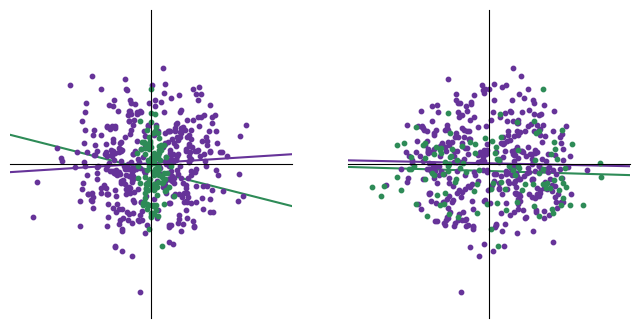

In [20]:
# Visualizing those 2 populations
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy() 
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
colors = ['rebeccapurple', 'seagreen']
fs = 12
clustering.pop_scatter_linreg(wi1, wi2, z, n_pops, colors=colors, ax=ax[0])
#clustering.pop_scatter_linreg(n, wi1, z, n_pops, colors=colors, ax=ax[0])
clustering.pop_scatter_linreg(n, wi2, z, n_pops, colors=colors, ax=ax[1])
#plt.savefig('./outputs/GNN_parameter_distribution.svg')

# Design input

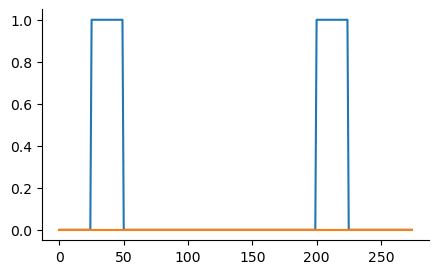

In [9]:
n_gains=20
stim1_begin, stim1_end, stim2_begin, stim2_end, decision = 25, 50, 200, 225, 275
epochs = [0, stim1_begin, stim1_end, stim2_begin, stim2_end, decision]
gain = np.linspace(1,0,n_gains)
    
input = torch.zeros(n_gains, decision, 2)
for i, g in enumerate(gain):
    input[i, stim1_begin:stim1_end, 0] = g
    input[i, stim2_begin:stim2_end, 0] = g
    
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.plot(input[0])
#plt.savefig('./outputs/stim.svg')

# Plot phase portraits of the original system for various parameters

In [21]:
n_traj=50

traj = generate_trajectories(net, input, epochs, n_traj, fname='./outputs/RNN_trajectories.pkl')

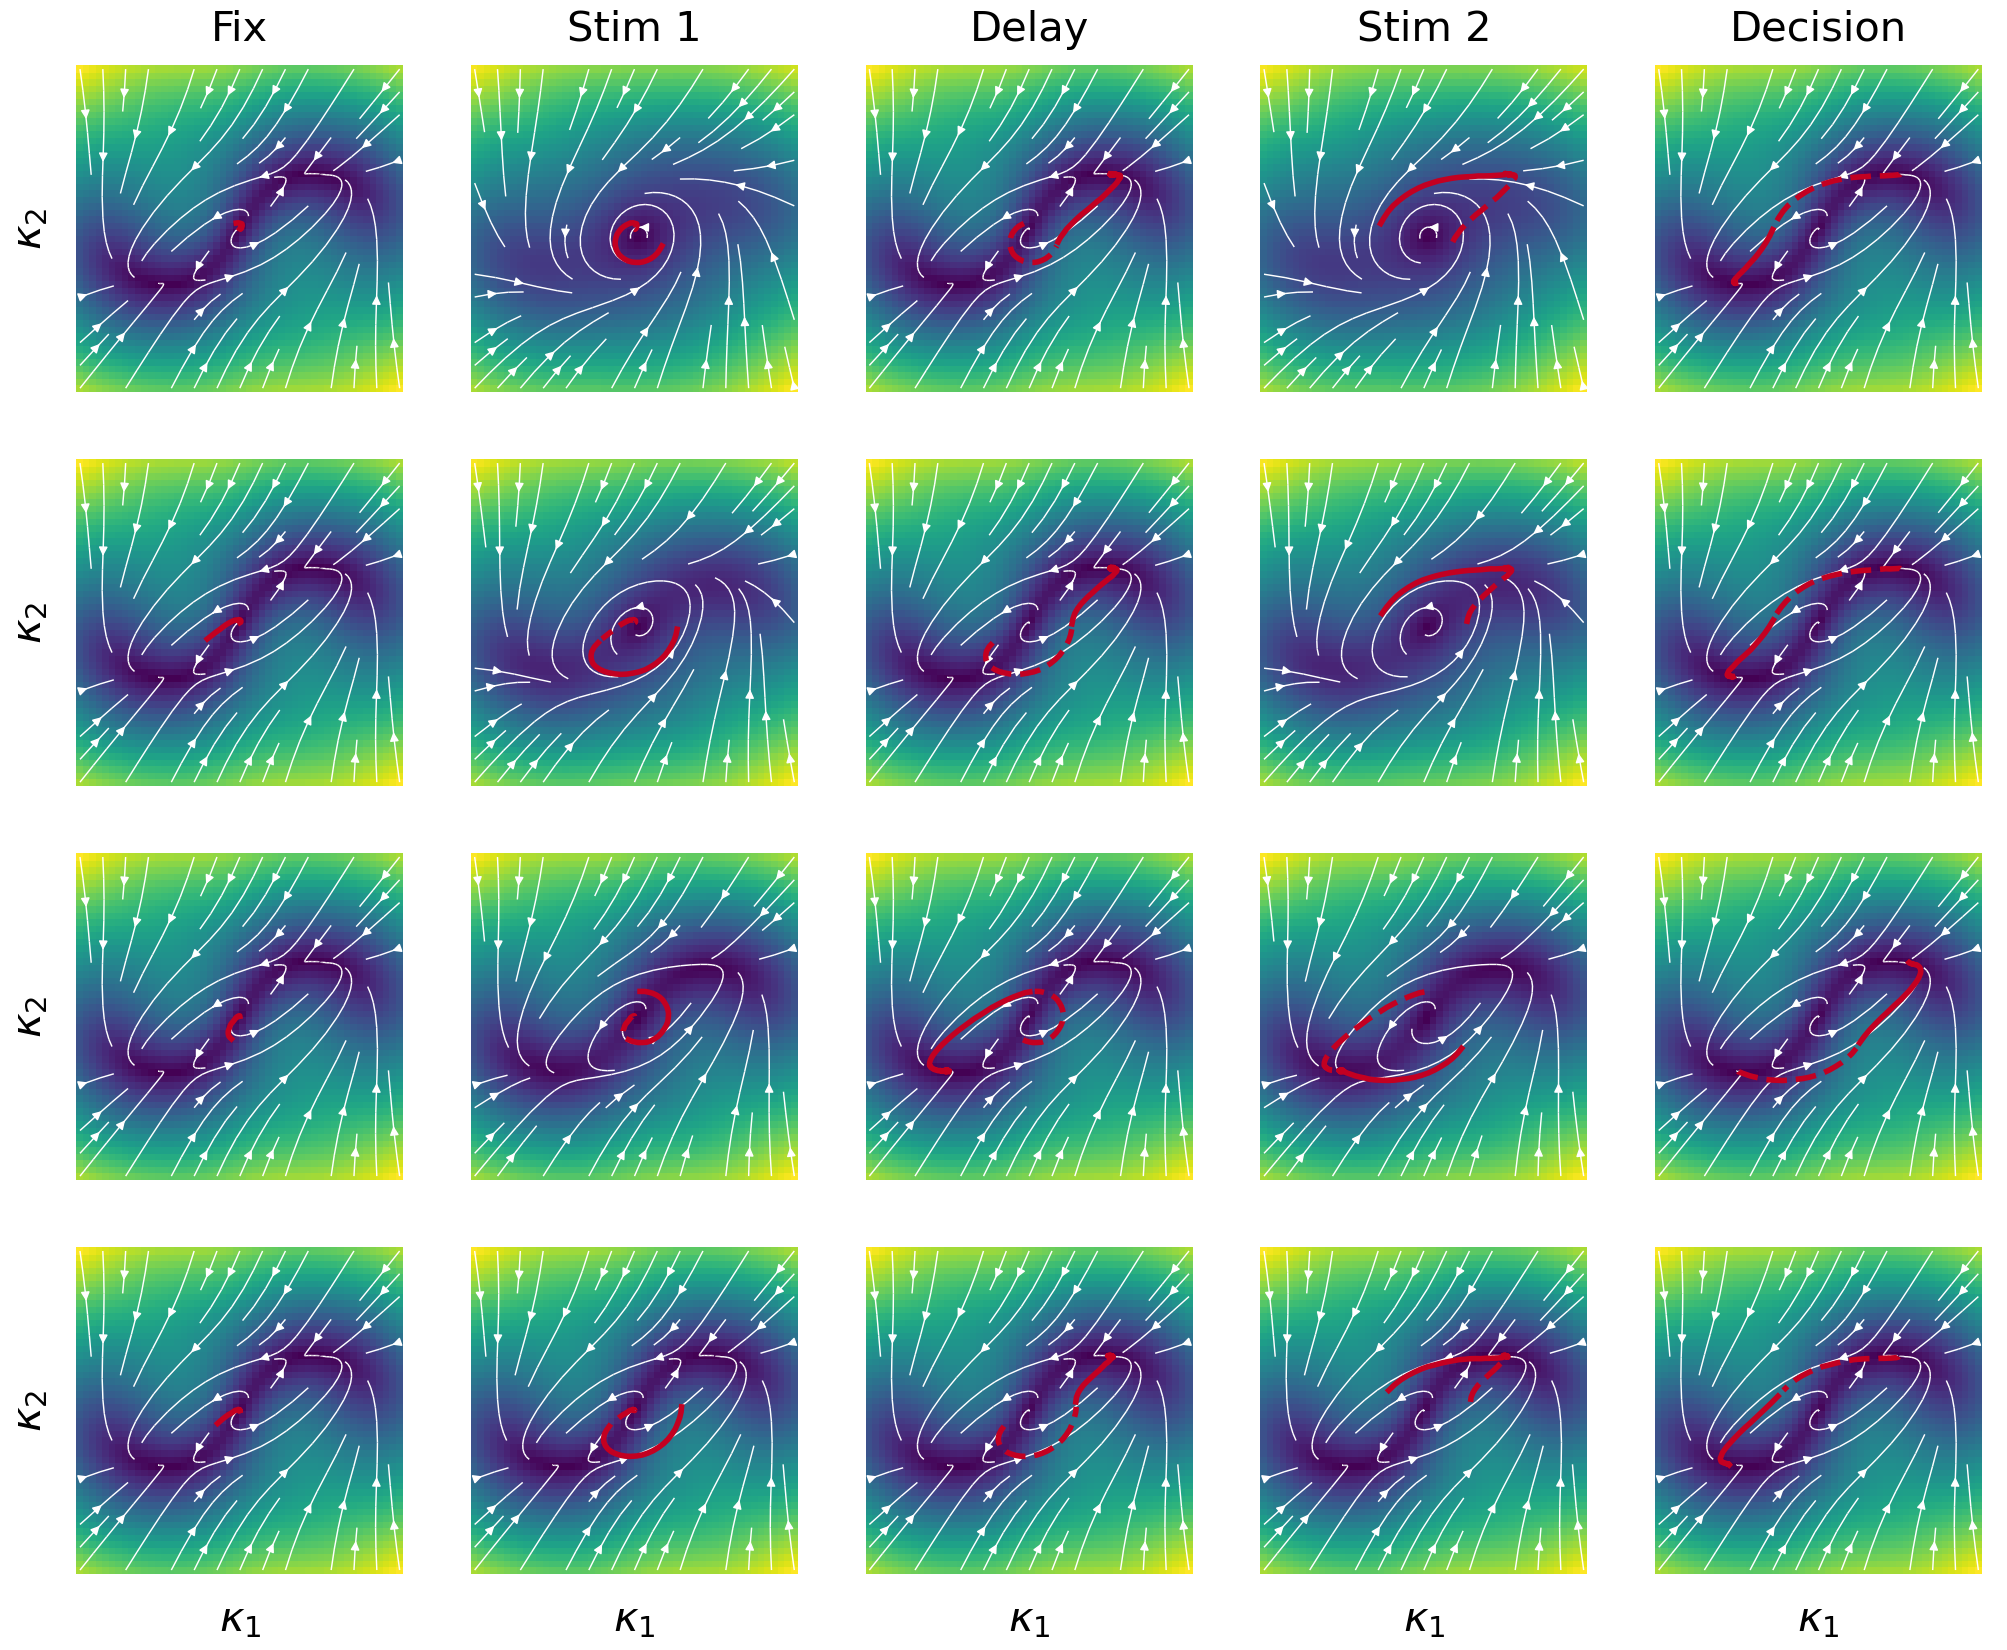

In [16]:
plot_experiment(net, input, traj, epochs, traj_to_show=1)

#plt.savefig('./outputs/fields_all_conditions.svg')

# Create new network by fitting Gaussian mixture to the connectivity space

In [ ]:
net_sampled = clustering.to_support_net(net, z, scaling=True)

Check that the resampled networks still give the same validation losses

In [ ]:
accs2 = []
for _ in range(10):
    net_sampled.resample_basis()
    loss, acc = dms.test_dms(net_sampled, x_val, y_val, mask_val)
    accs2.append(acc)

Train net network for a few epochs

In [ ]:
train(net_sampled, x_train, y_train, mask_train, 20, lr=1e-6, resample=True, keep_best=True, clip_gradient=1)

# Plot phase portraits of the resampled system for various parameters

In [ ]:
n_traj=50

traj_sampled = generate_trajectories(net_sampled, input, epochs, n_traj, fname='./outputs/RNN_trajectories_sampled.pkl')
plot_experiment(net_sampled, input, traj_sampled, epochs)

# Concatenate data and create dataset

In [22]:
pos, vel = aggregate_data(net, traj, epochs)
data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=15, stop_crit=0.02)

---- Embedding dimension: 500
---- Signal dimension: 500



Computing tangent bundle...:   0%|                                                                   | 0/40 [00:00<?, ?it/s]

Exception: 
Could not compute gauges (possibly data is too sparse or the                   number of neighbours is too small)

In [ ]:
titles = [r'$gain$ = {:0.2f}, {}'.format(g, s) for s in ['stim', 'unstim'] for g in gain ]

plotting.fields(data, col=4, alpha=0.2, width=0.01, scale=200, titles=titles)
plt.show()

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

par = {'epochs': 100, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 3,
       'inner_product_features': True,
      }

model = MARBLE.net(data, **par)
model.run_training(data)

In [ ]:
data = model.evaluate(data)
n_clusters=20
data = postprocessing(data, n_clusters=n_clusters)

emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
labels = [g for i in range(2) for g in gain ]
plotting.embedding(emb_MDS, labels, s=30, alpha=1)

In [ ]:
plt.imshow(data.dist)

In [ ]:
titles = [r'$gain$ = {:0.2f}, {}'.format(g, s) for s in ['stim', 'unstim'] for g in gain ]
labels = np.hstack([gain,gain])
plotting.embedding(data.emb_2d, data.y.numpy(), titles=titles)